In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
from sktime.datasets import load_arrow_head
from sklearn.metrics import accuracy_score
from sklearn.base import BaseEstimator
from tqdm import tqdm
import warnings


warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid", font_scale=1.2, palette="muted")
plt.rcParams["figure.figsize"] = [12, 4]

In [2]:
X_train, y_train = load_arrow_head(split="train", return_type="numpy2d")
X_test, y_test = load_arrow_head(split="test", return_type="numpy2d")

def study(method: BaseEstimator, seeds=range(20), **kwargs):
	return sum(
		accuracy_score(y_test, method(**kwargs, random_state=seed).fit(X_train, y_train).predict(X_test))
		for seed in tqdm(seeds)
	) / len(seeds)

## Regular Random Forest

In [3]:
from sklearn.ensemble import RandomForestClassifier
print(f"Random Forest Expected Accuracy: {study(RandomForestClassifier, n_estimators=100):.4f}")

100%|██████████| 20/20 [00:01<00:00, 11.22it/s]

Random Forest Expected Accuracy: 0.7023


## Time Series Forest Classifier

In [4]:
from sktime.classification.interval_based import TimeSeriesForestClassifier
print(f"Time Series Forest Expected Accuracy: {study(TimeSeriesForestClassifier, n_estimators=100):.4f}")

100%|██████████| 20/20 [00:09<00:00,  2.21it/s]

Time Series Forest Expected Accuracy: 0.7240


## Shapelet Random Forest

In [5]:
from sktime.classification.shapelet_based import ShapeletTransformClassifier
print(f"Shapelet Forest Expected Accuracy: {
	study(
		ShapeletTransformClassifier,
		estimator=RandomForestClassifier(n_estimators=100),
		n_shapelet_samples=800,
		max_shapelet_length=24,
	):.4f}"
)

100%|██████████| 20/20 [00:17<00:00,  1.13it/s]

Shapelet Forest Expected Accuracy: 0.7314


## Custom Random Forest

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from scipy.stats import linregress
from scipy.fft import fft
from tsfresh.feature_extraction.feature_calculators import mean, variance

class CustomRandomForest(RandomForestClassifier):
    def __init__(self, window_overlap=0.4, window_sizes=[0.2, 0.3], **rfkwargs):
        self.window_overlap = window_overlap
        self.window_sizes = window_sizes
        super().__init__(**rfkwargs)

    def fit(self, X_train, y_train):
        features = np.array([self.extract_features(series) for series in X_train])
        return super().fit(features, y_train)
    
    def predict(self, x):
        features = np.array([self.extract_features(series) for series in x])
        return super().predict(features)

    def segment_time_series(self, series):
        series = np.array(series)
        n = len(series)

        for win_ratio in self.window_sizes:
            win_size = int(n * win_ratio)
            step_size = max(1, int(win_size * (1 - self.window_overlap)))

            num_windows = (n - win_size) // step_size + 1
            start_indices = np.arange(0, num_windows * step_size, step_size)
            for start in start_indices:
                yield series[start:start + win_size]

    def extract_features(self, series):
        feature_vector = []
        
        for window in self.segment_time_series(series):
            mean_val = mean(window)
            std_val = np.sqrt(variance(window))
            slope_val, _, _, _, _ = linregress(range(len(window)), window)
            fft_vals = np.abs(fft(window))[:5]
            
            feature_vector.extend([mean_val, std_val, slope_val, *fft_vals])
        
        
        return np.array(feature_vector)

print(f"Custom Random Forest Expected Accuracy: {study(CustomRandomForest, n_estimators=100):.4f}")

100%|██████████| 20/20 [00:07<00:00,  2.71it/s]

Custom Random Forest Expected Accuracy: 0.7634


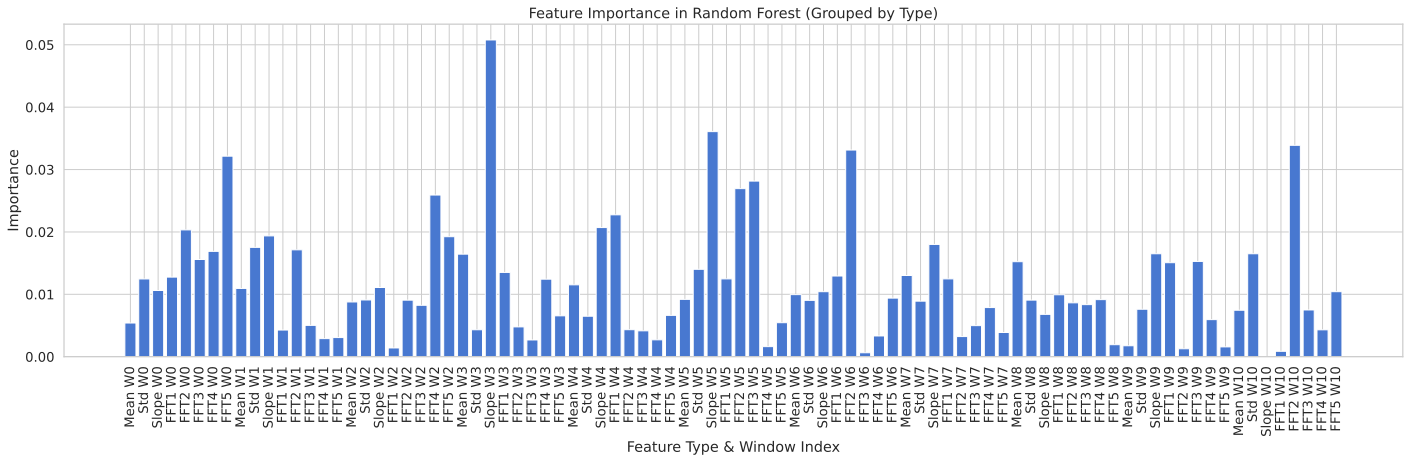

In [13]:
rf = CustomRandomForest()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)


# Improved Feature Importance Plot
feature_types = ["Mean", "Std", "Slope", "FFT1","FFT2","FFT3","FFT4", "FFT5"]
num_windows = len(rf.extract_features(X_train[0])) // len(feature_types)  # Each window has 8 features

feature_labels = [f"{ft} W{i}" for i in range(num_windows) for ft in feature_types]
importances = rf.feature_importances_

plt.figure(figsize=(24, 6))
plt.bar(feature_labels, importances)
plt.xticks(rotation=90)
plt.xlabel("Feature Type & Window Index")
plt.ylabel("Importance")
plt.title("Feature Importance in Random Forest (Grouped by Type)")
plt.show()